## Stock price prediction with RNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")

In [3]:
seq_length = 7
data_dim = 5
hidden_dim = 16
output_dim = 1
learning_rate = 0.01

In [4]:
data = np.loadtxt("./data-02-stock_daily.csv", delimiter=",") #원본데이터 최신 데이터가 먼저 있음
data = data[::-1]  # reverse order, 과거부터

- data.shape [732, 5]
- 시가, 최고가, 최저가, 거래량, 종가

In [5]:
data[0,:] 

array([  568.00257 ,   568.00257 ,   552.922516, 13100.      ,
         558.462551])

In [6]:
data.shape

(732, 5)

In [7]:
train_size = int(len(data)*0.7) #training set: 512개

In [8]:
train_set = data[:train_size]
test_set = data[train_size-seq_length:]

In [9]:
def minmax_scaling(data):#0~1로 normalize 
    numerator = data - np.min(data, axis=0)
    denominator = np.max(data, axis=0) - np.min(data, axis=0)
    return numerator/(denominator+1e-7)

In [10]:
train_set = minmax_scaling(train_set)
test_set = minmax_scaling(test_set)

In [11]:
def build_dataset(data, seq_length):
    dataX=[]
    dataY=[]
    
    for idx in range(len(data)-seq_length):
        dataX.append(data[idx:idx+seq_length, :])
        dataY.append(data[idx+seq_length, -1]) # 그 다음날 종가 맞추기
    return torch.FloatTensor(dataX), torch.FloatTensor(dataY)

In [12]:
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

In [13]:
print(trainX.shape)
print(trainY.shape)

torch.Size([505, 7, 5])
torch.Size([505])


In [14]:
class Stock_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(Stock_RNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x):
        outputs, (hidden_state, cell_state) = self.rnn(x)
        pred = self.fc(hidden_state)
        return torch.squeeze(pred)

- **output** of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features $h_t$ from the last layer of the LSTM, for each t
- **state** (hidden_state, cell_state) *at the last time step*.

In [15]:
model = Stock_RNN(data_dim, hidden_dim, output_dim, 1)

In [16]:
outputs, (hidden_state, cell_state) = model.rnn(trainX[:1,:,:])

In [17]:
print(outputs.shape)
print(hidden_state.shape)
print(cell_state.shape)

torch.Size([1, 7, 16])
torch.Size([1, 1, 16])
torch.Size([1, 1, 16])


In [18]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
for step in range(500):
    pred = model(trainX)
    loss = criterion(pred, trainY)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step%20==0:
        print(step, loss.item())

0 0.27589312195777893
20 0.0040781497955322266
40 0.0024895749520510435
60 0.002284025074914098
80 0.0022094715386629105
100 0.002139252843335271
120 0.002088162349537015
140 0.0020372429862618446
160 0.0019869746174663305
180 0.0019376147538423538
200 0.001889434177428484
220 0.0018426195019856095
240 0.0017972872592508793
260 0.0017535192891955376
280 0.0017114143120124936
300 0.0016711440403014421
320 0.0016329716891050339
340 0.0015971949324011803
360 0.0015640048077329993
380 0.0015333662740886211
400 0.001505067222751677
420 0.001478862133808434
440 0.0014545101439580321
460 0.0014317481545731425
480 0.0014103041030466557


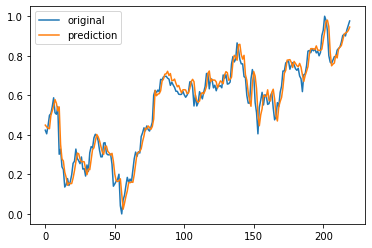

In [20]:
plt.plot(testY.data.numpy())
plt.plot(model(testX).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()